# Test on  QPU

In [1]:
from laboneq.simple import SHFQC
from laboneq.dsl.device import DeviceSetup, create_connection
import numpy as np
from copy import deepcopy
#instantiate ad device setup object
setup = DeviceSetup(uid="test_setup")
#add a dataserver
setup.add_dataserver(host="10.172.11.217", port="8004",uid="test_server")

setup.add_instruments(SHFQC(uid="test_shfqc",server_uid="test_server", address="DEV12576", device_options="SHFQC/PLUS/QC6CH"))

setup.instruments

[SHFQC(
│   uid='test_shfqc',
│   interface='1GbE',
│   connections=[],
│   server_uid='test_server',
│   address='DEV12576',
│   device_options='SHFQC/PLUS/QC6CH',
│   reference_clock_source=None,
│   device_class=0
)
]

In [2]:
for ch_idx, q_idx in enumerate([15,16,17,18,19]):# enumerate 안에 len(list) 강제하고싶음
    
    #QA
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/measure", ports="QACHANNELS/0/OUTPUT")) #signal_type="iq"
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/acquire", ports="QACHANNELS/0/INPUT" )) #signal_type="acquire"
    #SG
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_ef", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_cr", ports=f"SGCHANNELS/{ch_idx}/OUTPUT"))#signal_type="iq"


In [3]:
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from laboneq.dsl.quantum.qpu import QuantumElement

from krisszi_core.contrib.jsahn.operations import TransmonOperations
from krisszi_core.contrib.jsahn.transmon import TransmonQubit, TransmonQubitParameters
from krisszi_core.contrib.jsahn.helper import load_qubit_parameters, save_qubit_parameters

# # #TODO load_qubit_parameters should return list with TransmonQubit, currently it's a dict 
_loaded_qubits = load_qubit_parameters(filename="latest") 
loaded_qubits = list(_loaded_qubits.values())
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters")
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = loaded_qubits
quantum_operations = TransmonOperations()
qpu = QPU(quantum_elements=qubits, quantum_operations=quantum_operations)

# Create a demonstration QuantumPlatform for a transmon QPU:
quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)


from laboneq.simple import workflow
from pathlib import Path

folder_store = workflow.logbook.FolderStore("c:/Users/KRISS/Documents/KAIST/experiment_store")
folder_store.activate()
#folder_store.deactivate()


In [4]:
qpu

QPU(
│   quantum_elements=[
│   │   'q15',
│   │   'q16',
│   │   'q17',
│   │   'q18',
│   │   'q19'
│   ],
│   quantum_operations='TransmonOperations',
│   topology=QPUTopology(
│   │   edge_counts={}
│   )
)


In [5]:
for _, qubit in enumerate(qubits):
    
    
    ##################LOCAL OSCILLATOR FREQUENCY AND CHANNEL POWER ###################################
    qubit.parameters.drive_lo_frequency = 4.8e9
    qubit.parameters.readout_lo_frequency = 7.0e9
    qubit.parameters.readout_range_in =  0
    qubit.parameters.readout_range_out = -25
    qubit.parameters.drive_range = 0 
    
    
    
    ############READOUT PARAMETERS###################################################################
    qubit.parameters.readout_length - 2.0e-6
    qubit.parameters.readout_pulse['function'] = 'GaussianSquare'
    qubit.parameters.readout_pulse['sigma'] = 0.1
    qubit.parameters.readout_pulse['width'] = None
    qubit.parameters.readout_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.readout_amplitude = 1.0  #WARNING! 이거 SWEEP 할때 오버라이딩이 안되고 여기서 SCALING 됨
    
    
    ###########SPECTROSCOPY PARAMETERS###############################################################
    # Pulsed qubit spectroscopy drive ,  
    qubit.parameters.spectroscopy_pulse['function'] = 'GaussianSquare'
    qubit.parameters.spectroscopy_length = 5.0e-6
    qubit.parameters.spectroscopy_pulse['sigma'] = 0.2
    qubit.parameters.spectroscopy_pulse['width'] = None
    qubit.parameters.spectroscopy_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.spectroscopy_amplitude=0.01 
    
    
    ###########TRANSITION PARAMETERS#####################################
    qubit.parameters.ge_drive_amplitude_pi = 1.0
    qubit.parameters.ge_drive_amplitude_pi2 = 0.5
    qubit.parameters.ef_drive_amplitude_pi = 1.0
    qubit.parameters.ef_drive_amplitude_pi2 = 0.5 # Initialization just to avoid potential scaling problem
    

qubits[3].parameters.readout_amplitude = 0.5
qubits[4].parameters.readout_amplitude = 0.5
qubits[2].parameters.readout_amplitude = 0.5


In [6]:


from laboneq.simple import Session
session = Session(setup)
session.connect()

[2025.08.07 20:29:11.710] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is c:\Users\KRISS\Documents\KAIST\krisszi-core\src\krisszi_core\contrib\jsahn\laboneq_output\log
[2025.08.07 20:29:11.713] INFO    VERSION: laboneq 2.56.0
[2025.08.07 20:29:11.714] INFO    Connecting to data server at 10.172.11.217:8004
[2025.08.07 20:29:11.721] INFO    Connected to Zurich Instruments LabOne Data Server version 25.04.1.17 at 10.172.11.217:8004
[2025.08.07 20:29:11.733] INFO    Configuring the device setup
[2025.08.07 20:29:11.742] INFO    The device setup is configured


In [7]:
qubits[2].signals

{'drive': '/logical_signal_groups/q17/drive',
 'drive_ef': '/logical_signal_groups/q17/drive_ef',
 'drive_cr': '/logical_signal_groups/q17/drive_cr',
 'measure': '/logical_signal_groups/q17/measure',
 'acquire': '/logical_signal_groups/q17/acquire'}

In [8]:
setup.logical_signal_groups

{'q15': LogicalSignalGroup(
│   uid='q15',
│   logical_signals={
│   │   'measure': LogicalSignal(
│   │   │   uid='q15/measure',
│   │   │   direction=IODirection.OUT,
│   │   │   name='measure',
│   │   │   calibration=None,
│   │   │   path='/logical_signal_groups/q15/measure',
│   │   │   physical_channel=PhysicalChannel(
│   │   │   │   uid='test_shfqc/qachannels_0_output',
│   │   │   │   name='qachannels_0_output',
│   │   │   │   type=<PhysicalChannelType.IQ_CHANNEL: 'iq_channel'>,
│   │   │   │   path='/physical_channel_groups/test_shfqc/qachannels_0_output',
│   │   │   │   calibration=None
│   │   │   )
│   │   ),
│   │   'acquire': LogicalSignal(
│   │   │   uid='q15/acquire',
│   │   │   direction=IODirection.IN,
│   │   │   name='acquire',
│   │   │   calibration=None,
│   │   │   path='/logical_signal_groups/q15/acquire',
│   │   │   physical_channel=PhysicalChannel(
│   │   │   │   uid='test_shfqc/qachannels_0_input',
│   │   │   │   name='qachannels_0_input',
│   │   │

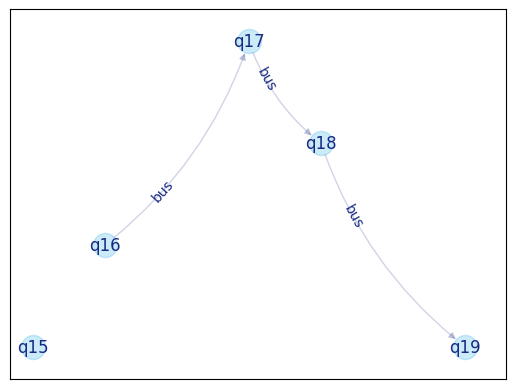

In [9]:
qpu.topology.add_edge("bus", "q16", "q17")
qpu.topology.add_edge("bus", "q17", "q18")
qpu.topology.add_edge("bus", "q18", "q19")
qpu.topology.plot()

In [10]:
for edges in qpu.topology.edges():
    print(edges)
for edges in qpu.topology.edge_keys():
    print(edges)

TopologyEdge(
│   tag='bus',
│   source_node='q16',
│   target_node='q17',
│   parameters=None,
│   quantum_element=None
)

TopologyEdge(
│   tag='bus',
│   source_node='q17',
│   target_node='q18',
│   parameters=None,
│   quantum_element=None
)

TopologyEdge(
│   tag='bus',
│   source_node='q18',
│   target_node='q19',
│   parameters=None,
│   quantum_element=None
)

('bus', 'q16', 'q17')
('bus', 'q17', 'q18')
('bus', 'q18', 'q19')


In [11]:
qubits[2].cr_parameters()

('drive_cr',
 {'amplitude': None,
  'length': None,
  'pulse': {'function': 'GaussianSquareDRAG',
   'sigma': 0.1,
   'risefall_sigma_ratio': 3.0,
   'beta0': 0.0,
   'beta1': 0.0}})

In [12]:
qubits[2].transition_parameters()

('drive',
 {'amplitude_pi': 1.0,
  'amplitude_pi2': 0.5,
  'length': 3.2e-08,
  'pulse': {'function': 'drag', 'beta': 0, 'sigma': 0.3}})

In [13]:
qubits[3].cr_parameters()

('drive_cr',
 {'amplitude': None,
  'length': None,
  'pulse': {'function': 'GaussianSquareDRAG',
   'sigma': 0.1,
   'risefall_sigma_ratio': 3.0,
   'beta0': 0.0,
   'beta1': 0.0}})

In [25]:
qpu.quantum_operations.set_frequency(q=qubits[3], frequency = 2e6)

LabOneQException: Not in an experiment context

In [23]:

qpu.quantum_operations.direct_cr(ctrl=qubits[3], targ=qubits[3])


Section(
│   uid='__direct_cr_0',
│   name='direct_cr',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[
│   │   Section(
│   │   │   uid='__cr_q18c_q18t_0',
│   │   │   name='cr_q18c_q18t',
│   │   │   alignment=SectionAlignment.LEFT,
│   │   │   execution_type=None,
│   │   │   length=None,
│   │   │   play_after=None,
│   │   │   children=[
│   │   │   │   PlayPulse(
│   │   │   │   │   signal='/logical_signal_groups/q18/drive_cr',
│   │   │   │   │   pulse=PulseFunctional(
│   │   │   │   │   │   function='GaussianSquareDRAG',
│   │   │   │   │   │   uid='__cr_pulse_0',
│   │   │   │   │   │   amplitude=1.0,
│   │   │   │   │   │   length=1e-07,
│   │   │   │   │   │   can_compress=False,
│   │   │   │   │   │   pulse_parameters={
│   │   │   │   │   │   │   'sigma': 0.1,
│   │   │   │   │   │   │   'risefall_sigma_ratio': 3.0,
│   │   │   │   │   │   │   'beta0': 0.0,
│   │   │   │   │   │   │   'beta1': 0.0
│   │  

In [ ]:
qpu.quantum_operations.prepare_state(q=qubits[2], state="e")

In [ ]:

qpu.quantum_operations.cr(ctrl=qubits[3], targ=qubits[3], length=300e-9)

In [ ]:
qubits[2].parameters.ge_drive_length

In [ ]:
import numpy as np
qpu.quantum_operations.ry(q=qubits[2], angle=np.pi/2)

In [ ]:
qpu.quantum_operations.prepare_state.omit_section(qubits[2],"e")

In [ ]:
qpu.quantum_operations.prepare_state(q=qubits[2])

In [ ]:
ctrl, targ = zip(s)

In [ ]:
ctr

In [ ]:
qpu.quantum_operations.create

TypeError: 'TransmonOperations' object is not callable

In [ ]:
from laboneq.simple import *
create

SyntaxError: invalid syntax (684593813.py, line 1)

In [22]:
from krisszi_core.contrib.jsahn.operations import create_pulse